## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
total_users=df.user_id.nunique()
total_users

290584

d. The proportion of users converted.

In [5]:
df[df['converted']==1].shape[0]/total_users

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df_01=df[(df['landing_page']=='new_page') & (df['group']!='treatment') | (df['landing_page']!='new_page') & (df['group']=='treatment')]
df_01.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()
#No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So it would be better to drop these rows to be confident about final results.

a. Store the new dataframe in **df2**.

In [8]:
#we should only include what will surely give us the right result.
df2=df[(df['landing_page']=='new_page') & (df['group']=='treatment') | (df['landing_page']!='new_page') & (df['group']!='treatment')]
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** :

a. How many unique **user_id**s are in **df2**?

In [10]:
number_of_users=df2.user_id.nunique()
number_of_users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
str(df2[df2['user_id'].duplicated()].user_id).split()[1]

'773192'

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2=df2.drop_duplicates(subset=['user_id'])

In [14]:
df2.shape

(290584, 5)

`4.` Use **df2** to calculate propotions

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
p_converted=df2[df2['converted']==1].shape[0]/df2.shape[0]
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control=df2[df2['group']=='control']
p_control_converted=df2[(df2['converted']==1 )& (df2['group']=='control')].shape[0]/control.shape[0]
p_control_converted


0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment=df2[df2['group']=='treatment']
p_treatment_converted=df2[(df2['converted']==1 )& (df2['group']=='treatment')].shape[0]/treatment.shape[0]
p_treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
p_new=df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]
p_new

0.5000619442226688

e.

**From parts (a) through (d) above, I don't think there is sufficient evidence as both conversions from new and old pages are extremely close. (nearly 12%)**

__Maybe we can run the treatment for longer time to check if this will provide a sufficient evidence to make our conclousion.__

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### Ho : **$p_{new}$** $\leq$  **$p_{old}$**
### H1 : **$p_{new}$**  $\gt$ **$p_{old}$**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new=p_converted
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=p_converted
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new=treatment.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old=control.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new],replace=True)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=np.random.choice([1,0],size=n_old,p=[p_old,1-p_old],replace=True)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean()-old_page_converted.mean()

-9.834690276755431e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [27]:
obs_diff=treatment.converted.mean()-control.converted.mean()

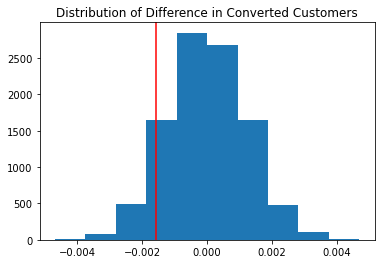

In [28]:
plt.hist(p_diffs);
plt.title('Distribution of Difference in Converted Customers')
plt.axvline(obs_diff , color='r');

Normally distributed, as expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
(p_diffs>obs_diff).mean()

0.9054

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In J, P-value was calcualted which is the probability of observing a statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
**If p-value is less than type 1 error we reject the null hypothesis, if it's larger we fail to reject the null hypothesis.**

**As P-value ==0.9062(>0.05) we fail to reject the null so we can say that the old page is better than the new one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old =control.converted.sum()
convert_new = treatment.converted.sum()
n_old = control.shape[0]
n_new = treatment.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, pval = sm.stats.proportions_ztest(count=[convert_new,convert_old], nobs=[n_new,n_old],alternative='larger')
z_score , pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score and p-value computed leads to failure to accept the null hypothesis as when pval>α⇒ Fail to Reject H0**

**Result agrees with part j. and k. as both are larger than type 1 error 0.05 and there will be no need to lauch the new page as conversion rates for the old one is higher.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept']=1
df2[['non_ab_page','ab_page']]=pd.get_dummies(df2['group'])
df2.drop(columns=['non_ab_page'],inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:57:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**P-value=0.190 (>0.05) which fails to reject the null hypothesis.**
**In part III The null hypothesis is p_new $\gt$ p_old which is the alternative in Part II.**
**Moreover, part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed).**
**Here we used the actual data points, but in part II we used smapling distribution to get these values** 

**To convert between them : $1-\frac{0.190}{2} = 0.905$

In [35]:
1-(0.190/2)

0.905

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering more factors may have a good impact on the output and it will tend to be more accurate, but in case of correlated explanatory variables, Our hypothesis testing results may not be reliable and that our coefficient estimates are less stable. That is, standard deviations associated with your regression coefficients are quite large.**

**So more variable might be useful for predicting the output, but because of the relationship it has with other variables, we will no longer see this association. This is called _multicollinearity_.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

Does it appear that country had an impact on conversion?

In [36]:
#joining countries column with the dataframe
df3=pd.read_csv('countries.csv')
df2=df2.join(df3.set_index('user_id'),on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [37]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
#gettig dummies of country column
df2[['US','UK','CA']]=pd.get_dummies(df2['country'])
df2.drop(columns=['CA'],inplace=True)

In [39]:
log_model=sm.Logit(df2['converted'],df2[['intercept','UK','US']])
results=log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Mar 2021   Pseudo R-squ.:               1.521e-05
Time:                        18:58:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [40]:
np.exp(0.0099) , np.exp(-0.0408)

(1.0099491671175422, 0.9600211149716509)

**Countries doesn't affect the conversion rate.**

h. Though We have now looked at the individual factors of country and page on conversion, We would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [41]:
df2['US_new'] = df2['US'] * df2['ab_page']
df2['UK_new'] = df2['UK'] * df2['ab_page']

In [42]:
log_model=sm.Logit(df2['converted'],df2[['intercept','ab_page','US','US_new','UK','UK_new' ]])
results=log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        18:58:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US_new        -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_new         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

- **P-values are greater than 0.05 thus they are not statically significant.**
- **Countries has no effect on Conversion rates.**

<a id='conclusions'></a>

## Conclousions
 In this Project, we applied statistics and logistic regression to understand A/B test results of e-commerce store website to decide if the new page should be launched or not. it turn out that the old page is better.
We analyzed the result using exact propotions, A/B testing and sampling distribution and logistic regression model and all of them lead to the same result of keeping the old page.
Maybe if we run the expirement for more time, more users will convert and our conclousion would be different but knowing that the probability an individual received the new page is 0.5 indicaties that there is equality in both groups.

## Refrences 
1. https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest
1. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html